In [3]:
import io
import requests

import torch
import datasets
from PIL import Image

from utils import draw_pose_pil_center_crop
from clapp.model import CLaPPModel

/Users/clement/text-to-pose/.venv/lib/python3.11/site-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(


In [4]:
dataset = datasets.load_dataset("clement-bonnet/coco_val2017_100_text_image_pose", split="test")
dataset

Dataset({
    features: ['file_name', 'license', 'coco_url', 'caption', 'id', 'pose'],
    num_rows: 100
})

In [5]:
clapp_model = CLaPPModel.from_pretrained("clement-bonnet/clapp-v0").eval()

In [6]:
captions, poses = [], []
for i in [0, 1, 2, 5, 25]:
    caption = dataset[i]["caption"]
    response = requests.get(dataset[i]["coco_url"])
    image = Image.open(io.BytesIO(response.content))
    pose_image = draw_pose_pil_center_crop(dataset[i]["pose"], pose_hw_ratio=image.height / image.width)
    poses.append(pose_image)
    captions.append(caption)

with torch.no_grad():
    clapp_scores = clapp_model.score(poses, captions)

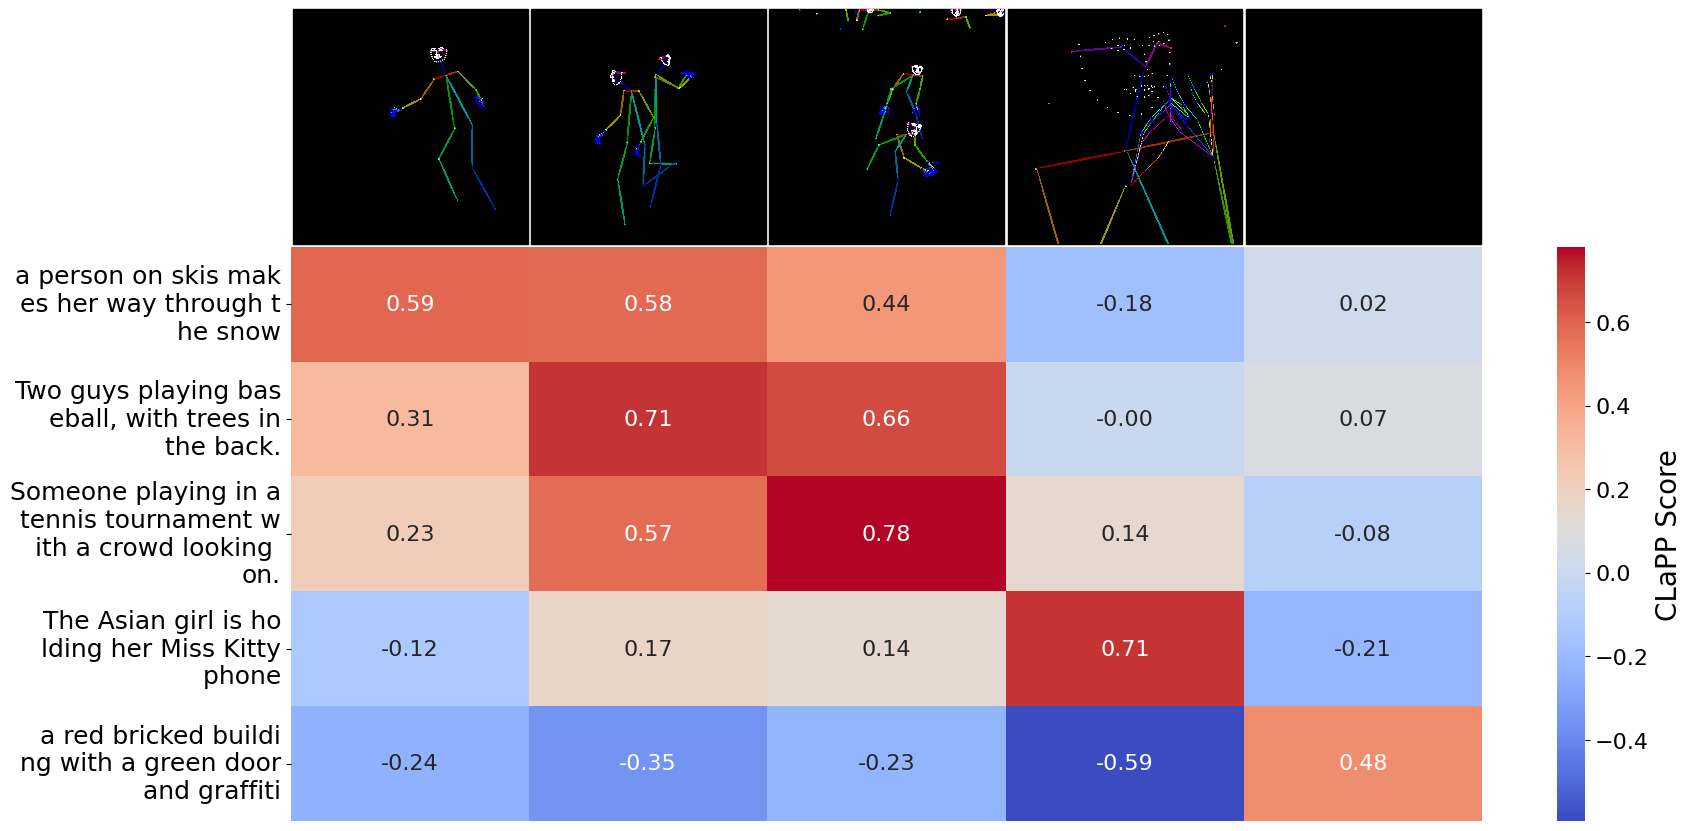

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.offsetbox import OffsetImage, AnnotationBbox


fig, ax = plt.subplots(figsize=(18, 8))
heatmap = sns.heatmap(clapp_scores, annot=True, fmt=".2f", cmap="coolwarm", ax=ax, cbar_kws={'label': 'CLaPP Score'}, annot_kws={"fontsize": 16})
ax.set_yticklabels(["\n".join(c[20*i:20*(i+1)] for i in range(len(c)//20 + 1)) for c in captions], rotation=0, fontsize=18)
ax.set_xticks([])
cbar = heatmap.collections[0].colorbar
cbar.set_label('CLaPP Score', size=20)
# Set fontsize of colorbar ticklabels
cbar.ax.tick_params(labelsize=16)

# Add images as column headers
for i, pose in enumerate(poses):
    imagebox = OffsetImage(pose, zoom=0.165)
    ab = AnnotationBbox(imagebox, (i, 5), xybox=(86, 500), boxcoords="offset points", pad=0.00, xycoords='data')
    ax.add_artist(ab)

plt.tight_layout()
plt.savefig("clapp_heatmap.pdf")
plt.show()